In [1]:
import os
import pickle
import pandas as pd
from metient.util import plotting_util as plutil
from metient.util import data_extraction_util as dutil
from metient.util.globals import *

REPO_DIR = os.path.join(os.getcwd(), "../../")
REPO_DIR

CUDA GPU: False


'/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/tracerx_analysis/../../'

In [2]:
PARAMS = "tracerx_trees_largebs_08122024"
METIENT_OUTPUT_DIR = os.path.join(REPO_DIR,'data', 'tracerx_nsclc', 'metient_outputs')
ORCHARD_OUTPUT_DIR = os.path.join(METIENT_OUTPUT_DIR, 'pyclone_clustered_orchard_trees')
CONIPHER_OUTPUT_DIR = os.path.join(METIENT_OUTPUT_DIR, f'{PARAMS}')
TRACERX_DATA_DIR = os.path.join(REPO_DIR,  "data", "tracerx_nsclc")
print(CONIPHER_OUTPUT_DIR)
CONIPHER_TREE_DIR = os.path.join(TRACERX_DATA_DIR, 'conipher_outputs/TreeBuilding/', )

MONO_COLOR = "#6aa84fff"
POLY_COLOR = "#2496c8ff"

MAX_K = float("inf") # Pareto front anyways

sample_info_df= pd.read_csv(os.path.join(TRACERX_DATA_DIR,"sample_overview_original.txt"), sep="\t")
sample_info_df

/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/tracerx_analysis/../../data/tracerx_nsclc/metient_outputs/tracerx_trees_largebs_08122024


,patient_id,tumour_id,region,sampleType,sampleTypeDetail
0,CRUK0010,CRUK0010,CRUK0010_SU_T1.R1,primary,primary
1,CRUK0010,CRUK0010,CRUK0010_SU_T1.R2,primary,primary
2,CRUK0010,CRUK0010,CRUK0010_SU_FLN1,metastasis,LN
3,CRUK0010,CRUK0010,CRUK0010_BR_LN1,metastasis,metachronousMet
4,CRUK0010,CRUK0010,CRUK0010_BR_LN2,metastasis,metachronousMet
...,...,...,...,...,...
689,CRUK0872,CRUK0872,CRUK0872_SU_T1.R1,primary,primary
690,CRUK0872,CRUK0872,CRUK0872_SU_T1.R2,primary,primary
691,CRUK0872,CRUK0872,CRUK0872_SU_T1.R3,primary,primary
692,CRUK0872,CRUK0872,CRUK0872_SU_T1.R4,primary,primary


In [3]:
import gzip
import torch

def get_patients(pickle_files_dir):
    patients = set()
    for file in os.listdir(pickle_files_dir):
        if ".pkl.gz" in file:
            name = file.split(".")[0].replace("_calibrate", "")
            patients.add(name)
    return patients

def patient_in_dict(dct, patient):
    for patient_primary in dct:
        if patient == patient_primary.split("_")[0]:
            return True, patient_primary, dct[patient_primary]
    return False, None, None

# def is_better_pattern(old_patterns, new_patterns):
#     for new_pattern in new_patterns:
#         if "monoclonal" in new_pattern or "monophyletic" in new_pattern:
#             return True
#     return False

def input_tree(patient):
    pid = patient.split("_")[0]
    tree_fn = os.path.join(CONIPHER_TREE_DIR, f"{pid}_conipher_SNVsallTrees_cleaned.txt")
    tree = dutil.get_adj_matrices_from_all_conipher_trees(tree_fn)[0]
    return tree

def get_seeding_sites(G, sites, patient):
    pid = patient.split("_")[0]
    seeding_indices = [int(x) for x in torch.where(torch.sum(G,dim=1))[0]]
    seeding = ['_'.join(sites[x].split("_")[1:]) for x in seeding_indices]
    patient_sample_info = sample_info_df[sample_info_df['patient_id']==pid]
    seeding_sites = set()
    for _,row in patient_sample_info.iterrows():
        for s in seeding:
            if s in row['region']:
                seeding_sites.add(row['sampleTypeDetail'])
    return list(seeding_sites)

def get_info(pickle_files_dir):
    patients = list(get_patients(pickle_files_dir))
    seeding_patterns = dict()
    for patient in patients:

        with gzip.open(os.path.join(pickle_files_dir, f"{patient}.pkl.gz"),'rb') as f:
            pckl = pickle.load(f)
        Vs = pckl[OUT_LABElING_KEY]
        As = pckl[OUT_ADJ_KEY]
        input_A = input_tree(patient)
        idx_to_labels = pckl[OUT_IDX_LABEL_KEY]
        loss_dicts = pckl[OUT_LOSS_DICT_KEY]
        losses = [l.item() for l in pckl[OUT_LOSSES_KEY]]
        sites = pckl[OUT_SITES_KEY]
        primary_label =  "_".join(patient.split("_")[1:])
        site_clonalities, gen_clonalities, patterns, phyleticities, tracerx_phyleticites = [],[],[],[],[]
        Gs = []
        gen_dist_losses = []
        seeding_sites = []
        
        for x, (V, A, loss_dict, idx_to_label) in enumerate(zip(Vs, As, loss_dicts, idx_to_labels)):
            if x > MAX_K:
                continue
            V = torch.tensor(V)
            A = torch.tensor(A)
            
            phyleticity = plutil.phyleticity(V, A, idx_to_label)
            tracerx_phyleticity = plutil.tracerx_phyleticity(V, A, idx_to_label)
            site_clonality = plutil.site_clonality(V, A)
            gen_clonality = plutil.genetic_clonality(V, A, idx_to_label)
            pattern = plutil.seeding_pattern(V, A)
            G = plutil.migration_graph(V,A)
            
            seeding_sites.append(get_seeding_sites(G,sites,patient))
            phyleticities.append(phyleticity)
            tracerx_phyleticites.append(tracerx_phyleticity)
            site_clonalities.append(site_clonality)
            gen_clonalities.append(gen_clonality)
            patterns.append(pattern)
            Gs.append(G)
            gen_dist_losses.append(float(loss_dict[GEN_DIST_KEY]))
        # For patients with multiple primaries
        patient_name = patient.split("_")[0]
        if patient_name in seeding_patterns:
            prev_best_loss = seeding_patterns[patient_name][-1][0]
            current_best_loss = losses[0]
            # choose the run with the lower loss
            if current_best_loss < prev_best_loss:
                seeding_patterns[patient_name] = site_clonalities, gen_clonalities, patterns, phyleticities, tracerx_phyleticites, Gs, gen_dist_losses, seeding_sites, losses
        else:
            seeding_patterns[patient_name] = site_clonalities, gen_clonalities, patterns, phyleticities, tracerx_phyleticites, Gs, gen_dist_losses, seeding_sites, losses

    print(f"{len(seeding_patterns)} patients")
    return seeding_patterns

### Load metient outputs using various combinations of clustering alg + tree inference alg + metient hyperparams

In [4]:
# (2) pyclone clusters + conipher trees + metient (maximum parsimony + genetic distance)
conipher_mp_gd_seeding_patterns = get_info(os.path.join(CONIPHER_OUTPUT_DIR, 'calibrate'))
inferred_patterns = conipher_mp_gd_seeding_patterns
print(len(inferred_patterns))
inferred_patterns

126 patients
126


{'CRUK0552': (['monoclonal'],
  ['monoclonal'],
  ['primary single-source'],
  ['monophyletic'],
  ['monophyletic'],
  [tensor([[0., 1.],
           [0., 0.]])],
  [1.0098872184753418],
  [['primary']],
  [51.00938415527344]),
 'CRUK0589': (['monoclonal'],
  ['monoclonal'],
  ['primary single-source'],
  ['monophyletic'],
  ['monophyletic'],
  [tensor([[0., 1.],
           [0., 0.]])],
  [2.399434804916382],
  [['primary']],
  [52.398834228515625]),
 'CRUK0766': (['monoclonal'],
  ['monoclonal'],
  ['primary single-source'],
  ['monophyletic'],
  ['monophyletic'],
  [tensor([[0., 1.],
           [0., 0.]])],
  [2.0001626014709473],
  [['primary']],
  [51.999874114990234]),
 'CRUK0598': (['monoclonal'],
  ['monoclonal'],
  ['primary single-source'],
  ['monophyletic'],
  ['monophyletic'],
  [tensor([[0., 1.],
           [0., 0.]])],
  [1.8361798524856567],
  [['primary']],
  [51.83585739135742]),
 'CRUK0510': (['polyclonal'],
  ['polyclonal'],
  ['primary single-source'],
  ['monophylet

### How many patients have different migration graphs in their Pareto front with met-to-met seeding

In [29]:
mult_nonpss_mig_graphs = set()

def add_tensor_to_set(tensor_set, new_tensor):
    for tensor in tensor_set:
        if torch.equal(tensor, new_tensor):
            return
    tensor_set.append(new_tensor)

pids_w_ln_ss, pids_w_distant_ss = set(),set()

for patient in inferred_patterns:
    seeding_sites = inferred_patterns[patient][7][0]
    
    if len(seeding_sites) > 1:
        print(patient,seeding_sites)
        #if 'LN' in seeding_sites:
            
        pids_w_mult_ss.add(patient)

print("Patients with met-to-met seeding:", len(pids_w_mult_ss), pids_w_mult_ss)


for patient in inferred_patterns:
    Gs = inferred_patterns[patient][5]
    gen_dist_losses = inferred_patterns[patient][6]
    if len(Gs) == 1: continue
    not_pss_Gs = []
    for G in Gs:
        mult_seeding_sites = len(torch.nonzero(G.sum(axis=1))) > 1
        if mult_seeding_sites:
            add_tensor_to_set(not_pss_Gs, G)
    
    if len(not_pss_Gs) > 1:
        mult_nonpss_mig_graphs.add(patient)

print("Patients with multiple unique mig graphs with met-to-met seeding", len(mult_nonpss_mig_graphs), mult_nonpss_mig_graphs)

CRUK0013 ['primary', 'LN']
CRUK0810 ['primary', 'LN']
CRUK0736 ['primary', 'LN']
CRUK0242 ['primary', 'metachronousMet']
CRUK0290 ['primary', 'LN']
CRUK0559 ['primary', 'LN']
CRUK0484 ['primary', 'metachronousMet']
CRUK0029 ['primary', 'LN']
CRUK0468 ['primary', 'LN']
CRUK0256 ['primary', 'LN']
CRUK0487 ['primary', 'LN']
CRUK0698 ['primary', 'LN']
CRUK0620 ['primary', 'LN']
CRUK0311 ['primary', 'LN']
CRUK0090 ['primary', 'metachronousMet']
CRUK0590 ['primary', 'metachronousMet']
Patients with met-to-met seeding: 16 {'CRUK0029', 'CRUK0013', 'CRUK0242', 'CRUK0487', 'CRUK0311', 'CRUK0290', 'CRUK0810', 'CRUK0559', 'CRUK0468', 'CRUK0590', 'CRUK0256', 'CRUK0620', 'CRUK0090', 'CRUK0736', 'CRUK0698', 'CRUK0484'}
Patients with multiple unique mig graphs with met-to-met seeding 7 {'CRUK0487', 'CRUK0290', 'CRUK0810', 'CRUK0559', 'CRUK0245', 'CRUK0698', 'CRUK0748'}


### Get sample info

In [6]:
import pandas as pd
sample_info_df= pd.read_csv(os.path.join(TRACERX_DATA_DIR,"sample_overview_original.txt"), sep="\t")
print(sample_info_df.head())


  patient_id tumour_id             region  sampleType sampleTypeDetail
0   CRUK0010  CRUK0010  CRUK0010_SU_T1.R1     primary          primary
1   CRUK0010  CRUK0010  CRUK0010_SU_T1.R2     primary          primary
2   CRUK0010  CRUK0010   CRUK0010_SU_FLN1  metastasis               LN
3   CRUK0010  CRUK0010    CRUK0010_BR_LN1  metastasis  metachronousMet
4   CRUK0010  CRUK0010    CRUK0010_BR_LN2  metastasis  metachronousMet


### How often are samples genetically monoclonal vs. polyclonal?

/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 77.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

monoclonal v.s. polyclonal: Welch's t-test independent samples, P_val=7.087e-10 stat=-7.197e+00


<Figure size 640x480 with 0 Axes>

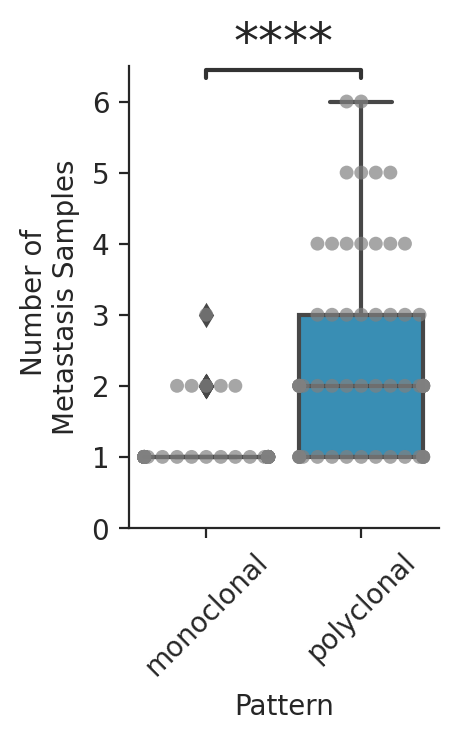

In [7]:
def get_num_met_samples(patient_id):
    sample_types = sample_info_df[sample_info_df['patient_id']==patient_id]['sampleType']
    return sample_types.value_counts()['metastasis']
    
mono_poly_data = {"mono_poly" : [], "num_samples" : [], "patient":[]}
for key, (_, gen_clonalities, _, _,_,_,_,_,_) in inferred_patterns.items():
    patient = key.split("_")[0]
    if "n/a" in gen_clonalities:
        assert(False)
        continue
    mono_poly_data['patient'].append(patient)
    mono_poly_data["mono_poly"].append(gen_clonalities[0])
    mono_poly_data["num_samples"].append(get_num_met_samples(patient))
#print(mono_poly_data)
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
fig = plt.figure(figsize=(2, 3), dpi=200)
palette = {"monoclonal":MONO_COLOR, "polyclonal":POLY_COLOR}
snsfig = sns.boxplot(x='mono_poly', y='num_samples', data=mono_poly_data, order=["monoclonal", "polyclonal"], linewidth=1.5, palette=palette, showfliers=True)
sns.swarmplot(x='mono_poly', y='num_samples', data=mono_poly_data, color="grey", dodge=False, alpha=0.7)  # Scatter plot
add_stat_annotation(snsfig, data=mono_poly_data, x='mono_poly', y='num_samples',
                    box_pairs=[("monoclonal", "polyclonal")], test='t-test_welch', text_format='star', loc='inside', verbose=1, fontsize=18, comparisons_correction=None)
plt.ylim(0, 6.5) 
plt.xlabel("Pattern")
plt.ylabel("Number of \nMetastasis Samples")
plt.xticks(rotation=45)
snsfig.spines['top'].set_visible(False)
snsfig.spines['right'].set_visible(False)
fig.savefig(os.path.join(REPO_DIR, "test/output_plots/tracerx", f"mono_vs_poly_num_samples_weight_exploration_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 

<Figure size 640x480 with 0 Axes>

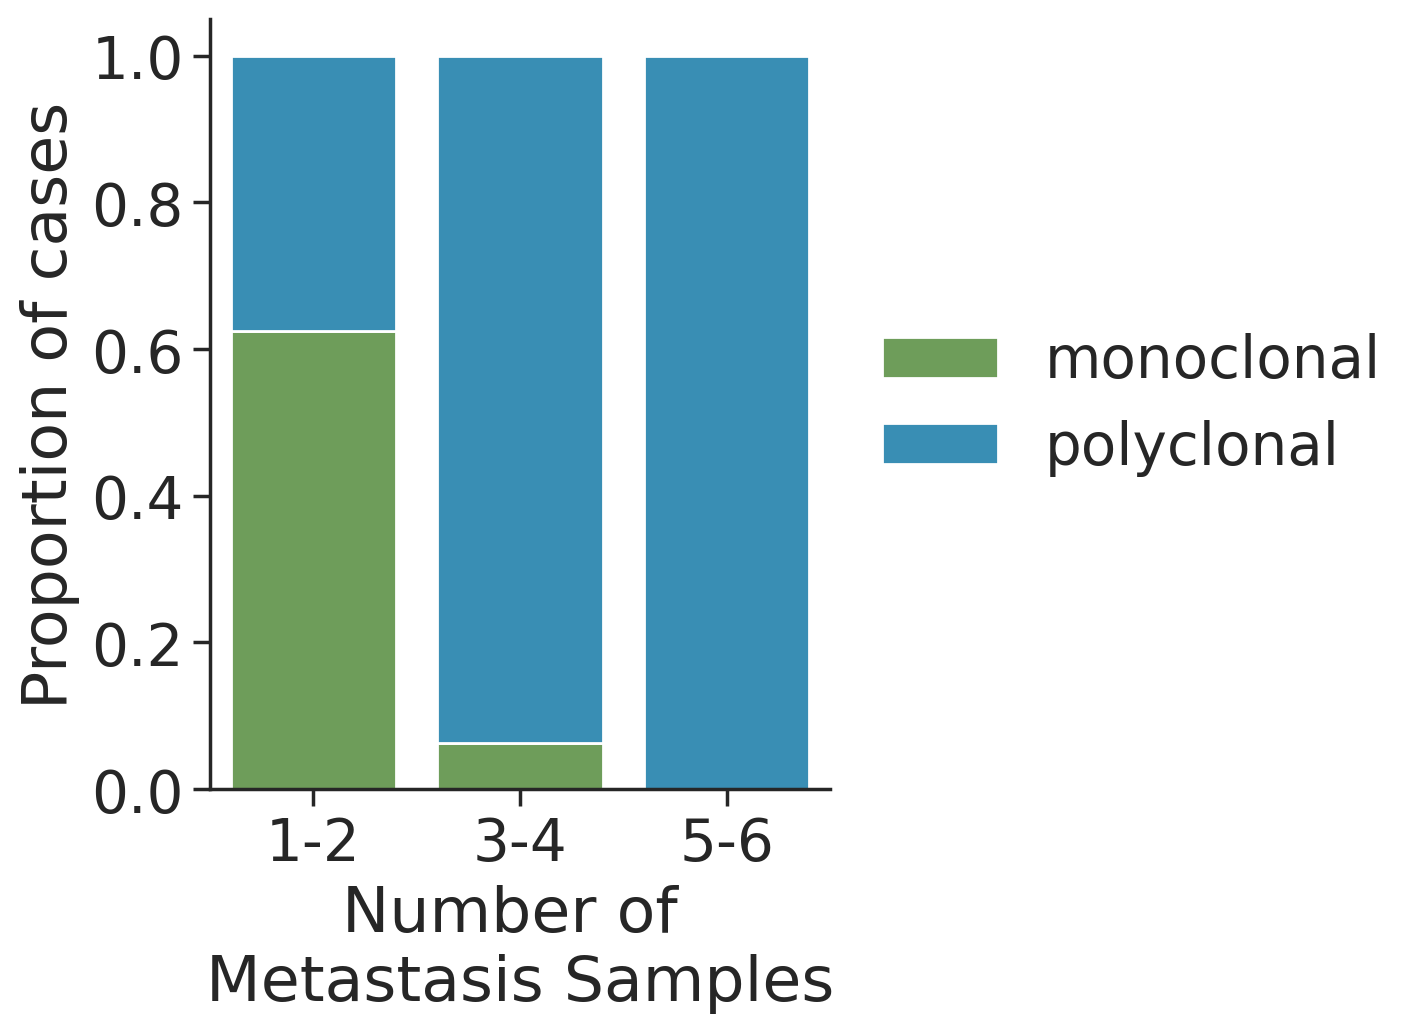

In [8]:
sns.set(font_scale=1.9)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
fig = plt.figure(figsize=(4, 5), dpi=200)
palette = {"monoclonal":"#00A088", "polyclonal":"#3B5587"}

# Create a DataFrame
num_samples_df = pd.DataFrame(mono_poly_data)

# Define the num_sites ranges
num_samples_df['num_samples_range'] = pd.cut(num_samples_df['num_samples'], bins=[0, 2, 4, 6], labels=["1-2", "3-4", "5-6"])

# Calculate the proportions of monoclonal and polyclonal within each range
proportions = num_samples_df.groupby(['num_samples_range', 'mono_poly']).size().unstack(fill_value=0).div(num_samples_df.groupby('num_samples_range').size(), axis=0)

# Reset the index
proportions.reset_index(inplace=True)

# Create a stacked bar plot
ax1 = sns.barplot(x='num_samples_range', y='monoclonal', data=proportions, color=MONO_COLOR, label='monoclonal')
ax2 = sns.barplot(x='num_samples_range', y='polyclonal', data=proportions, color=POLY_COLOR, bottom=proportions['monoclonal'], label='polyclonal')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add labels and legend
plt.xlabel("Number of \nMetastasis Samples")
plt.ylabel("Proportion of cases")
plt.title("")
plt.legend(title="",  loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)

# Show the plot
plt.show()
fig.savefig(os.path.join(REPO_DIR, "test/output_plots/tracerx", f"mono_vs_poly_prop_num_samples_weight_exploration_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 

In [9]:
num_samples_df[["mono_poly", "num_samples_range"]].value_counts()

mono_poly   num_samples_range
monoclonal  1-2                  65
polyclonal  1-2                  39
            3-4                  15
            5-6                   6
monoclonal  3-4                   1
dtype: int64

### How concordant are our seeding patterns with TRACERx's?

In [10]:
tracerx_seeding = pd.read_csv(os.path.join(TRACERX_DATA_DIR, "seedingTable.txt"), sep="\t")
tracerx_timing = pd.read_csv(os.path.join(TRACERX_DATA_DIR, "timingTable.txt"), sep="\t")

tracerx_seeding.columns = ["patient_id", "tracerx_clonality","tracerx_phyletic", "tracerx_multitree_adjustment"] 
print(len(tracerx_seeding))

def get_metient_patterns(row, pattern_idx):
    patient_id = row['patient_id'].split("_")[0]
    return ",".join(inferred_patterns[patient_id][pattern_idx])

tracerx_seeding['metient_genetic_clonalities'] = tracerx_seeding.apply(lambda row: get_metient_patterns(row, 1), axis=1)
tracerx_seeding['metient_tracerx_phyletics'] = tracerx_seeding.apply(lambda row: get_metient_patterns(row, 4), axis=1)
tracerx_seeding['metient_site_clonalities'] = tracerx_seeding.apply(lambda row: get_metient_patterns(row, 0), axis=1)
tracerx_seeding['metient_patterns'] = tracerx_seeding.apply(lambda row: get_metient_patterns(row, 2), axis=1)
tracerx_seeding['tracerx_timing'] = tracerx_seeding.apply(lambda row: tracerx_timing[tracerx_timing['tumour_id']==row['patient_id']]['timing'].item(), axis=1)

tracerx_seeding

126


,patient_id,tracerx_clonality,tracerx_phyletic,tracerx_multitree_adjustment,metient_genetic_clonalities,metient_tracerx_phyletics,metient_site_clonalities,metient_patterns,tracerx_timing
0,CRUK0010,monoclonal,monophyletic,monophyletic,"polyclonal,polyclonal","polyphyletic,polyphyletic","monoclonal,monoclonal","primary single-source,primary single-source",late
1,CRUK0013,monoclonal,monophyletic,monophyletic,"polyclonal,polyclonal","monophyletic,monophyletic","monoclonal,polyclonal","single-source,primary single-source",late
2,CRUK0284,monoclonal,monophyletic,monophyletic,"polyclonal,polyclonal","polyphyletic,polyphyletic","monoclonal,monoclonal","primary single-source,primary single-source",late
3,CRUK0361,monoclonal,monophyletic,monophyletic,monoclonal,monophyletic,monoclonal,primary single-source,late
4,CRUK0497,monoclonal,monophyletic,monophyletic,monoclonal,monophyletic,monoclonal,primary single-source,late
...,...,...,...,...,...,...,...,...,...
121,CRUK0495,polyclonal,monophyletic,monophyletic,polyclonal,polyphyletic,polyclonal,primary single-source,late
122,CRUK0476,monoclonal,monophyletic,monophyletic,"monoclonal,monoclonal","monophyletic,monophyletic","monoclonal,monoclonal","primary single-source,primary single-source",late
123,CRUK0528,polyclonal,polyphyletic,polyphyletic,polyclonal,polyphyletic,polyclonal,primary single-source,late
124,CRUK0666,polyclonal,polyphyletic,polyphyletic,"polyclonal,polyclonal","polyphyletic,polyphyletic","polyclonal,polyclonal","primary single-source,primary single-source",late


In [11]:
def num_matches(df, keys_matches):
    subset = df
    for key, match in keys_matches:
        subset = subset[df[key]==match]
    return len(subset)

num_matches(tracerx_seeding, [('tracerx_phyletic','polyphyletic'), ('tracerx_timing','late')])

/scratch/lsftmp/8767542.tmpdir/ipykernel_110176/3414694728.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = subset[df[key]==match]


16

In [12]:
tracerx_seeding['metient_genetic_clonality_first'] = tracerx_seeding.apply(lambda row: row['metient_genetic_clonalities'].split(",")[0], axis=1)
tracerx_seeding['metient_tracerx_phyletic_first'] = tracerx_seeding.apply(lambda row: row['metient_tracerx_phyletics'].split(",")[0], axis=1)

tracerx_seeding


,patient_id,tracerx_clonality,tracerx_phyletic,tracerx_multitree_adjustment,metient_genetic_clonalities,metient_tracerx_phyletics,metient_site_clonalities,metient_patterns,tracerx_timing,metient_genetic_clonality_first,metient_tracerx_phyletic_first
0,CRUK0010,monoclonal,monophyletic,monophyletic,"polyclonal,polyclonal","polyphyletic,polyphyletic","monoclonal,monoclonal","primary single-source,primary single-source",late,polyclonal,polyphyletic
1,CRUK0013,monoclonal,monophyletic,monophyletic,"polyclonal,polyclonal","monophyletic,monophyletic","monoclonal,polyclonal","single-source,primary single-source",late,polyclonal,monophyletic
2,CRUK0284,monoclonal,monophyletic,monophyletic,"polyclonal,polyclonal","polyphyletic,polyphyletic","monoclonal,monoclonal","primary single-source,primary single-source",late,polyclonal,polyphyletic
3,CRUK0361,monoclonal,monophyletic,monophyletic,monoclonal,monophyletic,monoclonal,primary single-source,late,monoclonal,monophyletic
4,CRUK0497,monoclonal,monophyletic,monophyletic,monoclonal,monophyletic,monoclonal,primary single-source,late,monoclonal,monophyletic
...,...,...,...,...,...,...,...,...,...,...,...
121,CRUK0495,polyclonal,monophyletic,monophyletic,polyclonal,polyphyletic,polyclonal,primary single-source,late,polyclonal,polyphyletic
122,CRUK0476,monoclonal,monophyletic,monophyletic,"monoclonal,monoclonal","monophyletic,monophyletic","monoclonal,monoclonal","primary single-source,primary single-source",late,monoclonal,monophyletic
123,CRUK0528,polyclonal,polyphyletic,polyphyletic,polyclonal,polyphyletic,polyclonal,primary single-source,late,polyclonal,polyphyletic
124,CRUK0666,polyclonal,polyphyletic,polyphyletic,"polyclonal,polyclonal","polyphyletic,polyphyletic","polyclonal,polyclonal","primary single-source,primary single-source",late,polyclonal,polyphyletic


In [13]:
set(tracerx_seeding['patient_id']) - set(inferred_patterns.keys())

{'CRUK0084_Tumour2',
 'CRUK0301_Tumour1',
 'CRUK0372_Tumour1',
 'CRUK0620_Tumour1',
 'CRUK0721_Tumour1'}

### How concordant are our characterizations of monoclonal/polyclonal with TRACERx

tracerx mono met mono 66
tracerx mono met poly 20 {'CRUK0810', 'CRUK0714', 'CRUK0256', 'CRUK0698', 'CRUK0013', 'CRUK0530', 'CRUK0284', 'CRUK0468', 'CRUK0559', 'CRUK0572', 'CRUK0087', 'CRUK0242', 'CRUK0452', 'CRUK0557', 'CRUK0299', 'CRUK0090', 'CRUK0010', 'CRUK0584', 'CRUK0745', 'CRUK0702'}
tracerx poly met poly 40
tracerx poly met mono 0 set()
                                       Method  Number of cases
0                                  Monoclonal               66
1                                  Polyclonal               40
2  Metient: Polyclonal, \nTRACERx: Monoclonal               20
3  Metient: Monoclonal, \nTRACERx: Polyclonal                0


<Figure size 640x480 with 0 Axes>

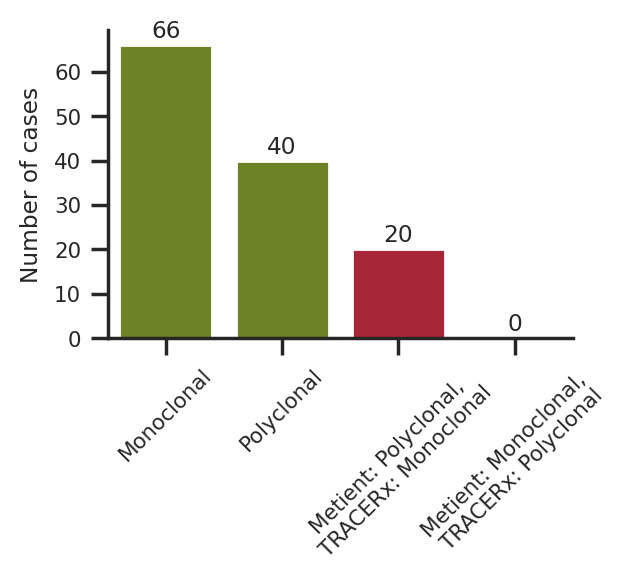

In [14]:

num_tracerx_mono_met_mono = len(tracerx_seeding[(tracerx_seeding['tracerx_clonality']=="monoclonal")&(tracerx_seeding['metient_genetic_clonality_first']=="monoclonal")])
print("tracerx mono met mono", (num_tracerx_mono_met_mono))
tracerx_mono_met_poly = tracerx_seeding[(tracerx_seeding['tracerx_clonality']=="monoclonal")&(tracerx_seeding['metient_genetic_clonality_first']=="polyclonal")]
num_tracerx_mono_met_poly = len(tracerx_mono_met_poly)
print("tracerx mono met poly", (num_tracerx_mono_met_poly), set(tracerx_mono_met_poly['patient_id']))
num_tracerx_poly_met_poly = len(tracerx_seeding[(tracerx_seeding['tracerx_clonality']=="polyclonal")&(tracerx_seeding['metient_genetic_clonality_first']=="polyclonal")])
print("tracerx poly met poly", (num_tracerx_poly_met_poly))
tracerx_poly_met_mono = tracerx_seeding[(tracerx_seeding['tracerx_clonality']=="polyclonal")&(tracerx_seeding['metient_genetic_clonality_first']=="monoclonal")]
num_tracerx_poly_met_mono = len(tracerx_poly_met_mono)
print("tracerx poly met mono", (num_tracerx_poly_met_mono), set(tracerx_poly_met_mono['patient_id']))


data = [["Monoclonal", num_tracerx_mono_met_mono], 
        ["Polyclonal",num_tracerx_poly_met_poly], 
        ["Metient: Polyclonal, \nTRACERx: Monoclonal",num_tracerx_mono_met_poly],
        ["Metient: Monoclonal, \nTRACERx: Polyclonal",num_tracerx_poly_met_mono],]
df = pd.DataFrame( data,columns=["Method", "Number of cases"])
print(df)
sns.set(font_scale=0.7)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
fig = plt.figure(figsize=(3, 2), dpi=200)
sns.set_palette(sns.color_palette(["#759116", "#759116", "#bf1029", "#bf1029"]))
ax = sns.barplot(data=df, x="Method", y="Number of cases", hue="Method",dodge=False)
ax.legend().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points')
# Add labels and legend
plt.xlabel("")
plt.ylabel("Number of cases")
plt.xticks(rotation=45)
fig.savefig(os.path.join(REPO_DIR, "test/output_plots/tracerx", f"clonality_consensus_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 


### How concordant are our characterizations of monophyletic/polyphyletic with TRACERx

tracerx mono met mono 80
tracerx mono met poly 27 ['CRUK0010', 'CRUK0284', 'CRUK0472', 'CRUK0702', 'CRUK0590', 'CRUK0620_Tumour1', 'CRUK0609', 'CRUK0714', 'CRUK0290', 'CRUK0745', 'CRUK0087', 'CRUK0299', 'CRUK0530', 'CRUK0325', 'CRUK0465', 'CRUK0090', 'CRUK0029', 'CRUK0035', 'CRUK0372_Tumour1', 'CRUK0487', 'CRUK0467', 'CRUK0514', 'CRUK0557', 'CRUK0559', 'CRUK0762', 'CRUK0810', 'CRUK0495']
tracerx poly met poly 16
tracerx poly met mono 0 []
total 123


<Figure size 640x480 with 0 Axes>

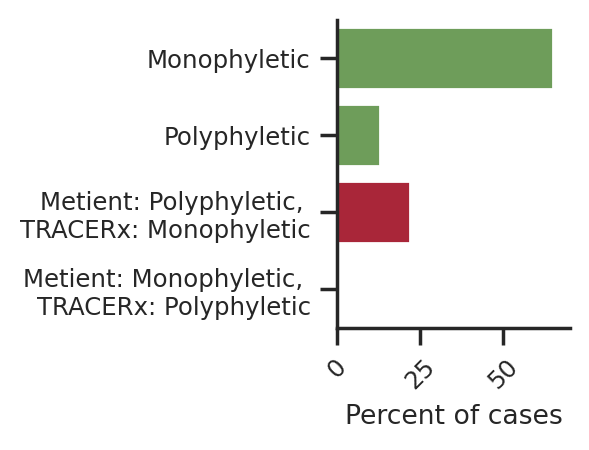

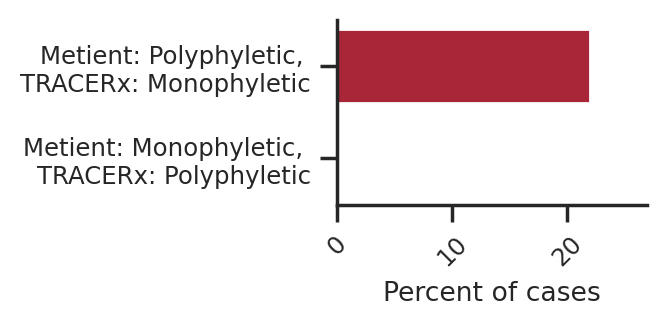

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix

def phyletic_consensus(data, output_name, colors, size, rotate=45):
    # Bar chart
    df = pd.DataFrame(data,columns=["Method", "Number of cases"])
    sns.set(font_scale=0.8, font="Arial")
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.despine()
    fig = plt.figure(figsize=(size[0], size[1]), dpi=200)
    sns.set_palette(sns.color_palette(colors))
    ax = sns.barplot(data=df, x="Number of cases", y="Method",  hue="Method", dodge=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend().set_visible(False)

    # Add labels and legend
    plt.ylabel("")
    plt.xlabel("Percent of cases")
    plt.xlim(0,max([x[1] for x in data])+5)
    plt.xticks(rotation=rotate)
    fig.savefig(os.path.join(REPO_DIR, "test/output_plots/tracerx", f"phyletic_consensus_{output_name}_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 
    
    
num_tracerx_mono_met_mono = len(tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="monophyletic")&(tracerx_seeding['metient_tracerx_phyletic_first']=="monophyletic")])
print("tracerx mono met mono", (num_tracerx_mono_met_mono))
tracerx_mono_met_poly = tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="monophyletic")&(tracerx_seeding['metient_tracerx_phyletic_first']=="polyphyletic")]
num_tracerx_mono_met_poly = len(tracerx_mono_met_poly)
print("tracerx mono met poly", (num_tracerx_mono_met_poly), list(tracerx_mono_met_poly['patient_id']))
num_tracerx_poly_met_poly = len(tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="polyphyletic")&(tracerx_seeding['metient_tracerx_phyletic_first']=="polyphyletic")])
print("tracerx poly met poly", (num_tracerx_poly_met_poly))
tracerx_poly_met_mono = tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="polyphyletic")&(tracerx_seeding['metient_tracerx_phyletic_first']=="monophyletic")]
num_tracerx_poly_met_mono = len(tracerx_poly_met_mono)
print("tracerx poly met mono", (num_tracerx_poly_met_mono), list(tracerx_poly_met_mono['patient_id']))
total = num_tracerx_mono_met_mono+num_tracerx_mono_met_poly+num_tracerx_poly_met_poly+num_tracerx_poly_met_mono
print("total", total)
data = [["Monophyletic", 100*(num_tracerx_mono_met_mono/total)], 
        ["Polyphyletic",100*(num_tracerx_poly_met_poly/total)], 
        ["Metient: Polyphyletic, \nTRACERx: Monophyletic",100*(num_tracerx_mono_met_poly/total)],
        ["Metient: Monophyletic, \nTRACERx: Polyphyletic",100*(num_tracerx_poly_met_mono/total)],]

phyletic_consensus(data, "", ["#6aa84f", "#6aa84f", "#bf1029", "#bf1029"], (1.5,2))

# Only show disagreement
data = [["Metient: Polyphyletic, \nTRACERx: Monophyletic",100*(num_tracerx_mono_met_poly/total)],
        ["Metient: Monophyletic, \nTRACERx: Polyphyletic",100*(num_tracerx_poly_met_mono/total)],]
phyletic_consensus(data, "disagreement", ["#bf1029", "#bf1029"], (2,1.2), rotate=45)



In [16]:
tracerx_poly_met_mono = tracerx_seeding[(tracerx_seeding['tracerx_multitree_adjustment']=="polyphyletic")&(tracerx_seeding['metient_tracerx_phyletics'][0]=="monophyletic")]
tracerx_poly_met_mono_pids = list(tracerx_poly_met_mono['patient_id'].unique())
print(len(tracerx_poly_met_mono_pids))


from collections import Counter
num_seeding_sites = []
for pid in tracerx_poly_met_mono_pids:
    if pid in inferred_patterns:
        best_G = inferred_patterns[pid][5][0]
        non_zero_rows = torch.unique(best_G.nonzero()[:, 0])
        num_non_zero_rows = len(non_zero_rows)
        num_seeding_sites.append(num_non_zero_rows)

ctr = Counter(num_seeding_sites)
ctr
    

0


Counter()

### How concordant are our characterizations of single-source/multi-source with TRACERx (which assumes primary single-source)

126
primary single-source    110
single-source             15
multi-source               1
Name: source, dtype: int64
                  Source  Counts
0  primary single-source     110
1          single-source      15
2           multi-source       1


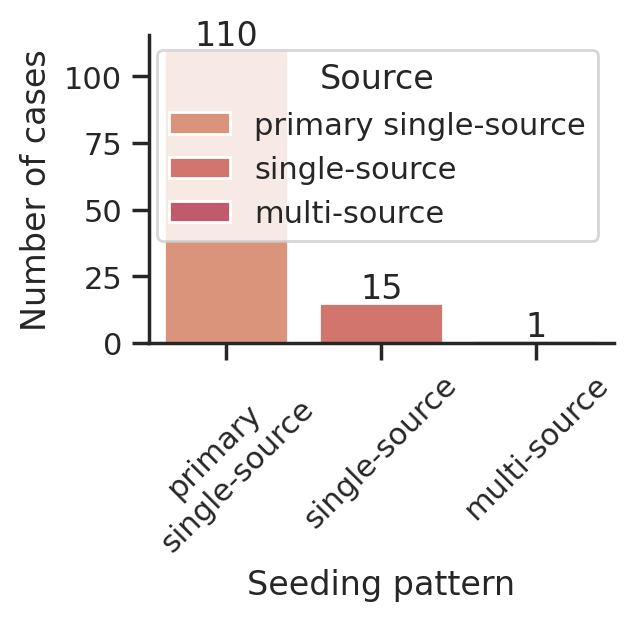

In [17]:
data = {"mono_poly" : [], "source" : [], "patient":[]}

    
for key, (_, _, patterns,_, _, _,_,_,_) in inferred_patterns.items():
    patient = key.split("_")[0]
    pattern = patterns[0]
    data["patient"].append(patient)
    data["mono_poly"].append(pattern.split()[0])
    data["source"].append(pattern)
print(len(data["source"]))
# Create a DataFrame
top_pattern_df = pd.DataFrame(data)
print(top_pattern_df['source'].value_counts())
top_counts = top_pattern_df['source'].value_counts().reset_index()
top_counts.columns = ['Source', 'Counts']
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
sns.set_style("ticks")
#sns.set_palette(sns.color_palette(["#6aa84f", "#c27ba0", "#e69138", "#6fa8dc"]))
sns.set_palette(sns.color_palette("flare"))
print(top_counts)
custom_labels = ["\n".join(label.split()) for label in top_pattern_df['source'].value_counts().index]
fig = plt.figure(figsize=(3, 2), dpi=200)
ax = sns.barplot(data=top_counts,x='Source',y='Counts',  hue="Source", dodge=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points')

    

plt.xlabel("Seeding pattern")
plt.ylabel("Number of cases")
plt.xticks(rotation=45, ticks=range(len(custom_labels)), labels=custom_labels)
plt.savefig(os.path.join(REPO_DIR, "test/output_plots/tracerx", f"verbose_source_distribution_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 
plt.show()


In [18]:
top_pattern_df[top_pattern_df['source']!='primary single-source']

,mono_poly,source,patient
8,single-source,single-source,CRUK0013
13,single-source,single-source,CRUK0810
28,single-source,single-source,CRUK0736
33,single-source,single-source,CRUK0242
42,multi-source,multi-source,CRUK0290
49,single-source,single-source,CRUK0559
55,single-source,single-source,CRUK0484
57,single-source,single-source,CRUK0029
66,single-source,single-source,CRUK0468
68,single-source,single-source,CRUK0256


[110, 126] [16, 0]


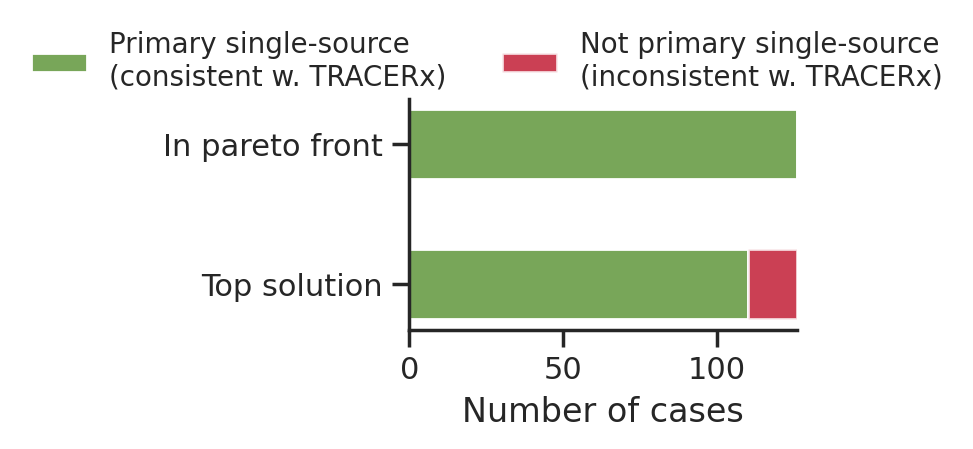

In [19]:
# Create a horizontal stacked bar chart using Seaborn

topk_prim_single_source = len(tracerx_seeding[(tracerx_seeding['metient_patterns'].str.contains("primary single-source"))])

fig = plt.figure(figsize=(2.5, 1.5), dpi=200)
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
sns.set_style("ticks")
ax = fig.add_subplot(111)
ys = ['Top solution', f'In pareto front']
top_prim_single_source_count = top_counts[top_counts['Source']=='primary single-source']['Counts'].item()
prim_single_source_counts = [top_prim_single_source_count, topk_prim_single_source]
not_prim_single_source_counts = [len(inferred_patterns)-x for x in prim_single_source_counts]
print(prim_single_source_counts, not_prim_single_source_counts)
ax.barh(ys, prim_single_source_counts, align='center', alpha=1, height=.5, color='#78a659',label='Primary single-source\n(consistent w. TRACERx)')
ax.barh(ys, not_prim_single_source_counts, align='center', alpha=0.8, height=.5, left=prim_single_source_counts, color="#bf1029",label='Not primary single-source\n(inconsistent w. TRACERx)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.2, 1.4), frameon=False, fontsize=10)

plt.xlabel("Number of cases")
plt.ylabel("  ")
#plt.xticks(rotation=0, ticks=range(len(custom_labels)), labels=custom_labels)
plt.savefig(os.path.join(REPO_DIR, "test/output_plots/tracerx", f"concordance_prim_single_source_{PARAMS}.png"), dpi=600, bbox_inches='tight', pad_inches=0.5) 
plt.show()
